In [2]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Raw 40 Features

Use these features to run random forest, xgboost, if the results are not very bad (no need to be very good either in this project), run lime and generate rules

In [3]:
kdd99_40raw = pd.read_csv('kdd99_raw40.csv')
print(kdd99_40raw.shape)
kdd99_40raw.head()

(1074992, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,src_dst_bytes_diff,attack_type,attack_type_cat
0,0,1,24,9,215,45076,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,44861,11,normal.
1,0,1,24,9,162,4528,0,0,0,0,...,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4366,11,normal.
2,0,1,24,9,236,1228,0,0,0,0,...,0.0,0.50,0.0,0.0,0.0,0.0,0.0,992,11,normal.
3,0,1,24,9,233,2032,0,0,0,0,...,0.0,0.33,0.0,0.0,0.0,0.0,0.0,1799,11,normal.
4,0,1,24,9,239,486,0,0,0,0,...,0.0,0.25,0.0,0.0,0.0,0.0,0.0,247,11,normal.


In [4]:
object_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 
               'root_shell', 'su_attempted', 'is_guest_login', 'attack_type']

In [5]:
factor = pd.factorize(kdd99_40raw['attack_type_cat'])
print(factor[0])
print(factor[1])
print(np.unique(factor[0], return_counts=True))

[0 0 0 ... 0 0 0]
Index(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
       'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
       'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.', 'phf.',
       'nmap.', 'multihop.', 'warezmaster.', 'warezclient.', 'spy.',
       'rootkit.'],
      dtype='object')
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int64), array([812814,     30,      9,      3, 242149,   3007,     53,    206,
          918,   3564,   3723,     19,      8,    968,     12,   5019,
            4,   1554,      7,     20,    893,      2,     10],
      dtype=int64))


### NOTE!

* When using built-in functions for multi-class classification, it's better to factorize the categorical labels instead of using encoding, because factorizing will generate numbers in the same order as the original labels, encoding won't obey the original order.

In [6]:
for col in object_cols:
    kdd99_40raw[col] = kdd99_40raw[col].apply(str)

In [7]:
y_cat = kdd99_40raw['attack_type_cat']
y = pd.DataFrame(factor[0])
X = kdd99_40raw.iloc[:, 0:-2]
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,src_dst_bytes_diff
0,0,1,24,9,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,44861
1,0,1,24,9,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4366
2,0,1,24,9,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,992
3,0,1,24,9,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,1799
4,0,1,24,9,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,247


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y[0], test_size = 0.3, random_state = 10, stratify=y[0])

In [9]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
np.unique(y_test, return_counts=True) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22], dtype=int64),
 array([243844,      9,      3,      1,  72645,    902,     16,     62,
           275,   1069,   1117,      6,      2,    290,      4,   1506,
             1,    466,      2,      6,    268,      1,      3],
       dtype=int64))

In [41]:
class_weights = {0:1, 1:1000, 2:2000, 3:2000, 4:1, 5:2, 6:1000, 7:500, 
                 8:100, 9:2, 10:2, 11:1000, 12:2000, 13:100, 14:2000, 15:2,
                16:2000, 17:100, 18:2000, 19:1000, 20:100, 21: 2000, 22: 2000}

clf = RandomForestClassifier(n_estimators = 27, criterion = 'entropy', n_jobs = 4, random_state = 10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=4,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [42]:
y_pred = clf.predict(X_test)

In [43]:
# copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes, title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [44]:
kdd99_40raw['attack_type_cat'].value_counts()

normal.             812814
neptune.            242149
satan.                5019
ipsweep.              3723
portsweep.            3564
smurf.                3007
nmap.                 1554
back.                  968
teardrop.              918
warezclient.           893
pod.                   206
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
land.                   19
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: attack_type_cat, dtype: int64

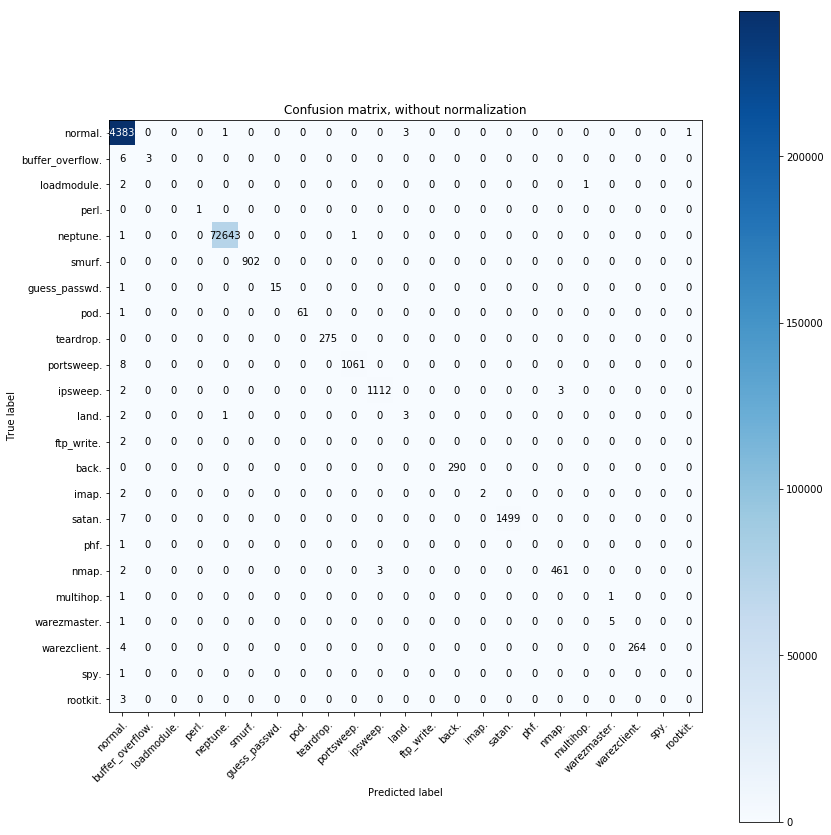

In [45]:
np.set_printoptions(precision=2)
class_names = factor[1]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

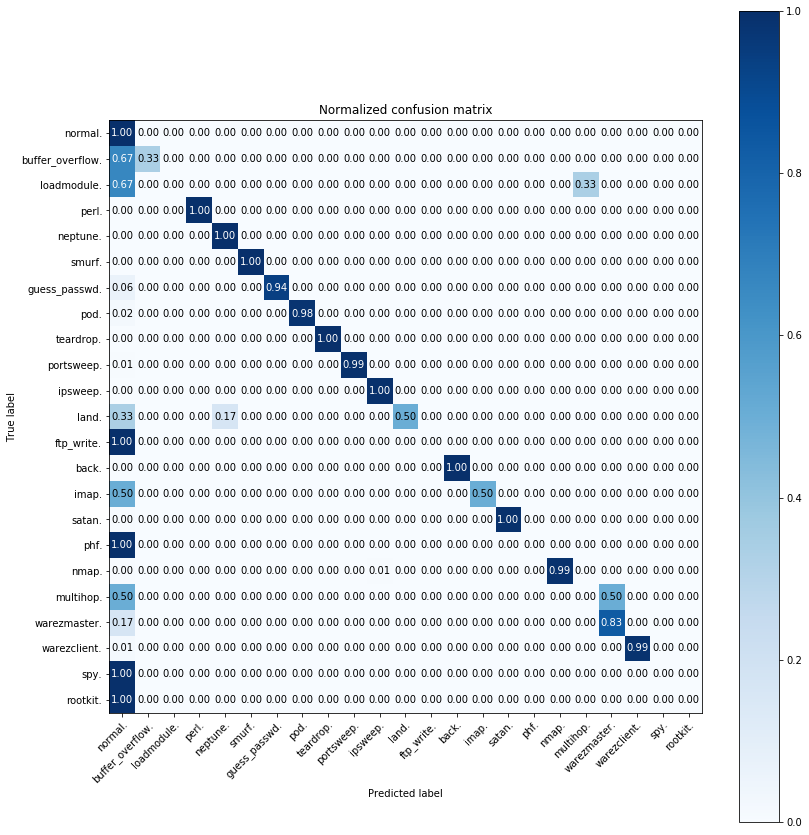

In [46]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Normalized confusion matrix', normalize=True)
plt.show()

In [ ]:
# reverse weights and see
# run lime